# Problem Set 2
### Lukas Hager,  ECON 532
___

## Market Simulation
**For each of these two simulations, compare the distribution of prices, profits and consumer surplus. For consumer surplus, simulate draws of consumers from the true distribution and calculate their optimal purchasing decision and welfare**
___
To get prices, we simply squeeze the variable `P_opt` to be one dimensional and plot a histogram. To get profit, we need only to generate the marginal costs, and to get and consumer surplus, we use the fact that when $\varepsilon$ is distributed as a Type 1 Extreme Value, 
$$\mathbb{E}\left[\max_i\delta_i + \varepsilon_i\right] = .5772 + \log\left(\sum_{i=1}^j\exp(\delta_j)\right)$$ 
Then, we calculate 
$$\pi_{jm} = \text{Market Share} \times \text{Consumers} \times \left(p_{jm} - mc_{jm}\right)$$
and
$$CS_{im} = \frac{1}{\alpha_{i}}\max_{j}U_{ijm}$$

In [92]:
# import libraries
import numpy as np
import numpy.random as rand
import pandas as pd
import scipy as sp
from scipy import optimize as op
from scipy.io import loadmat
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

source_path = '/Users/hlukas/git/uw_grad_school_code/ECON-532/Assignment 2/pset2_upload/Simulated Data/{}markets{}products.mat'
gamma = np.array([2,1,1]).reshape(3,1)
alpha = 1.
sigma_alpha = 1.
beta = np.array([5.,1.,1.]).reshape((3,1))

In [93]:
# function to import the data into python

def import_data(mkts,prods):
    mat_data = loadmat(source_path.format(mkts,prods))
    variable_names = [x for x in mat_data.keys() if x not in ['__header__', '__version__', '__globals__']]
    return([mat_data[x] for x in variable_names])

In [94]:
# function to plot prices

def plot_prices(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    p_flat = P_opt.reshape(prods * mkts)
    plt.hist(p_flat, bins=int(np.ceil(p_flat.max() - np.min([0., np.min(p_flat)]))*2), ec='black', range=(np.floor(np.min([0., np.min(p_flat)])), np.ceil(p_flat.max())))
    plt.title('Price Distribution ({} Products, {} Markets)'.format(prods, mkts))
    plt.xlabel('Price')
    plt.ylabel('Products')
    plt.show()

In [95]:
# function to plot profits

def plot_profit(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]
    
    # get the marginal cost
    mc_jm = np.column_stack([np.ones(prods * mkts),w, Z]) @ gamma + eta
    markup = P_opt.T - mc_jm.reshape(mkts, prods)

    profit = markup * shares.T * n_consumers
    
    profit_flat = profit.reshape(prods * mkts)
    plt.hist(profit_flat, bins='fd', ec = 'black')
    plt.title('Profit Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Profit')
    plt.ylabel('Products')

The way that we calculate consumer surplus requires a little more explication. We know that
$$U_{ijm} = X_{jm}\beta - p_{jm}\alpha_i + \xi_{jm} + \epsilon_{ijm}$$
We can instead write utility as a $im\times j$ matrix, so that each row represents a consumer/market combination, and each column is a given product. We can do this by getting the utility that doesn't depend on the consumer, stacking that matrix $i$ times, stacking the price and $\xi$ matrix $i$ times, and creating an $\alpha$ matrix by repeating each $\alpha_i$ $j$ times:

In [96]:
def plot_cs(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i
    alpha_i = alphas.reshape(-1,1) - 1.

    # get the market-product mean utility
    u_jm = (x1 @ beta + xi_all - P_opt.T.reshape(-1,1)).reshape(mkts, prods)

    # create a big system
    u_big = np.repeat(u_jm, n_consumers, axis = 0)
    p_big = np.repeat(P_opt.T, n_consumers, axis = 0)

    # get the CS
    u = u_big - alpha_i * p_big
    cs = (.5772 + np.log(np.sum(np.exp(u), axis = 1))) / (alpha_i + 1.).squeeze()
    cs_mean = np.mean(cs.reshape(100,500).clip(0), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

#### Price Plots
___

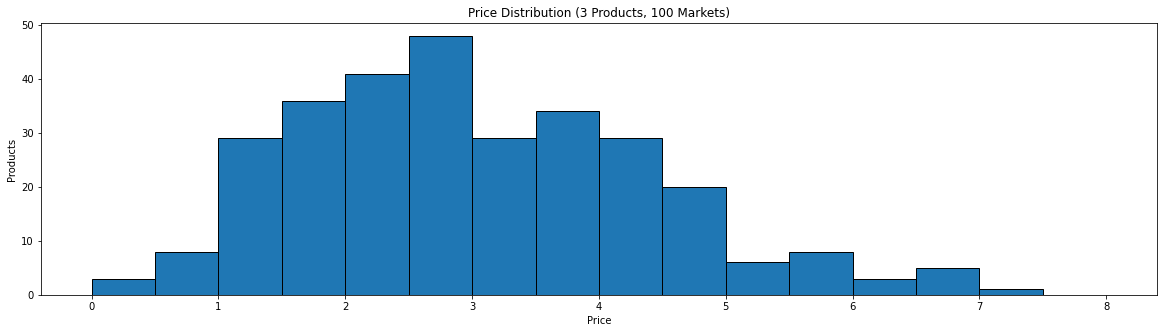

In [97]:
plot_prices(100,3)

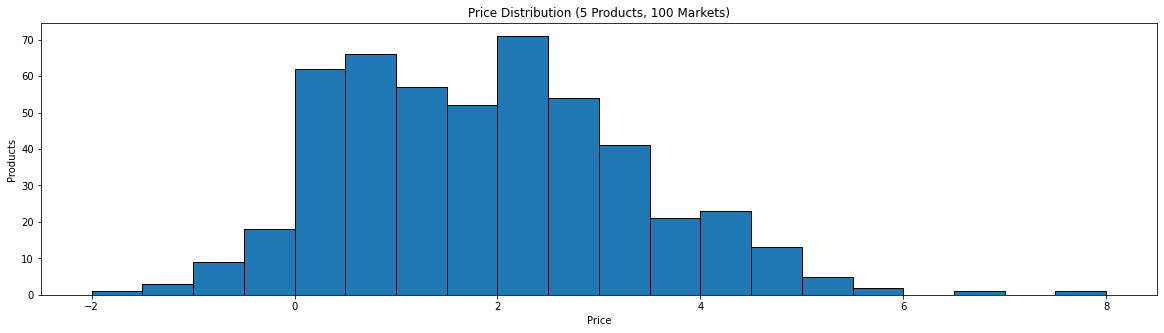

In [98]:
plot_prices(100,5)

Prices appear to be higher in the 3 good market compared to the 5 good market; this makes sense, as in a competitive market, more competition should drive down the prices that firms can charge.

#### Profit Plots
___

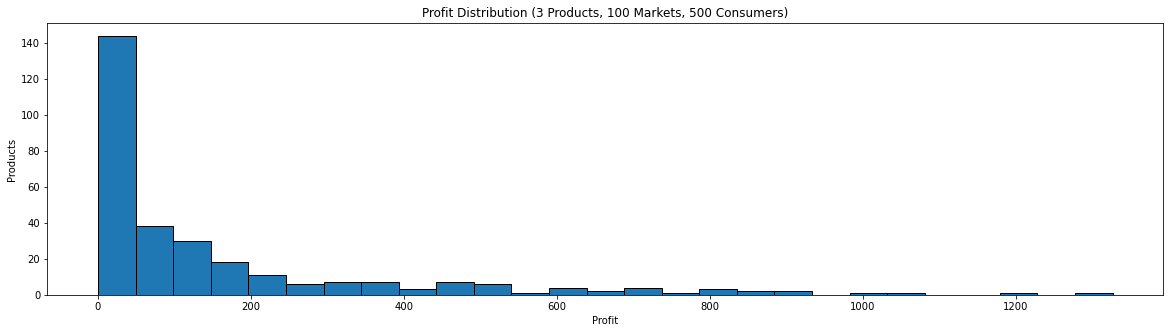

In [99]:
plot_profit(100,3)

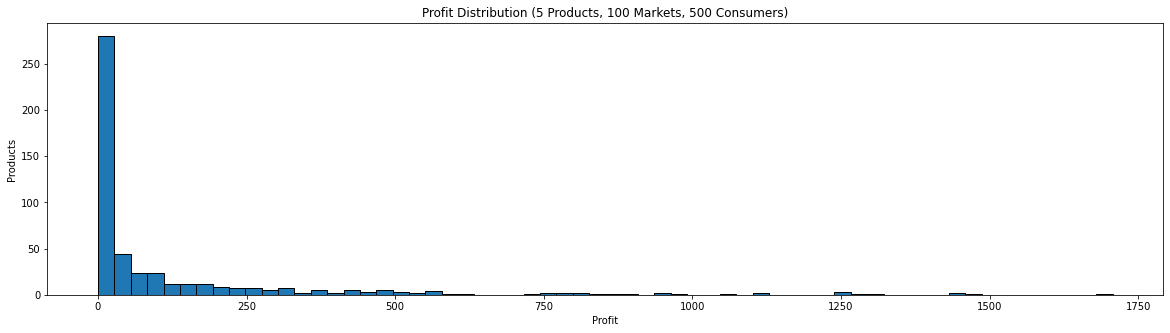

In [100]:
plot_profit(100,5)

The takeaway is similar to the above; when there is more competition, the profits of firms decrease, and the distribution is shifted towards lower amounts of profit.

#### Consumer Surplus Plots
___

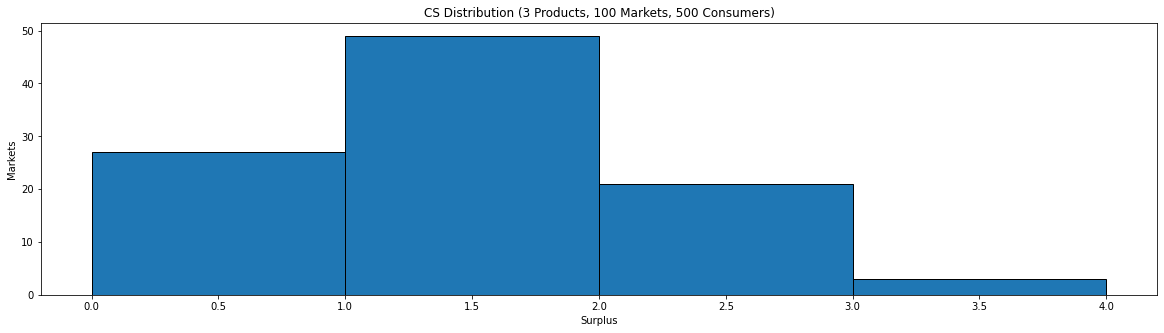

In [101]:
plot_cs(100,3)

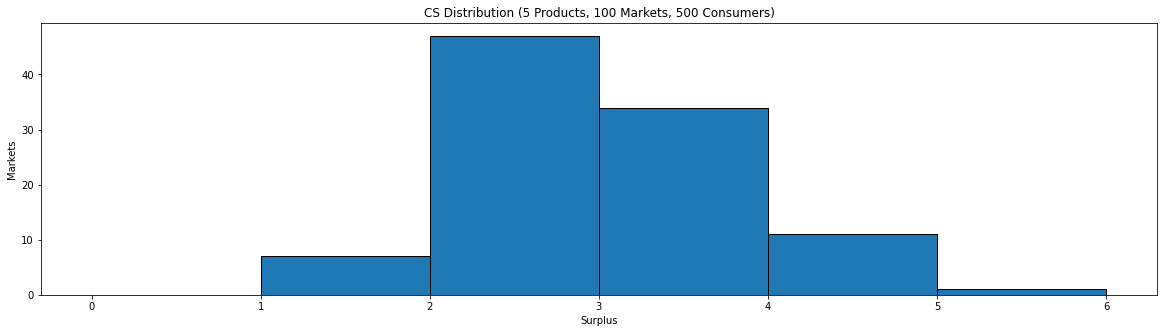

In [102]:
plot_cs(100,5)

Here, we see a large difference. When there are more options, the consumer surplus increases significantly.

## BLP and Nevo Instruments
___

**1a**. See below

In [103]:
# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(100,3)

# xi/X
xi_X = np.mean(x1 * np.tile(xi_all, (1,3)), axis = 0)

# xi/p
xi_p = np.mean(P_opt.T * xi_all.reshape((100,3)))

# xi/p_hat
# to get p_hat, we compute average prices across other markets
p_hat = np.tile(
    np.array([np.mean(np.delete(P_opt.T,x,0)) for x in range(len(P_opt.T))]).reshape((100,1)),
    (1,3)
)

p_hat = np.row_stack([np.mean(np.delete(P_opt.T,x,0), axis = 0) for x in range(len(P_opt.T))])

xi_p_hat = np.mean(p_hat * xi_all.reshape((100,3)))

In [104]:
xi_X

array([0.04346104, 0.02074192, 0.0355315 ])

In [105]:
xi_p

0.2949581371489729

In [106]:
xi_p_hat

0.14367954767468022

**1b**. It appears that $\mathbb{E}[\xi_{jm}X_{jm}] \approx 0$ and $\mathbb{E}[\xi_{jm}\overline{p}_{jm}] \approx 0$, so these conditions are likely roughly valid. Additionally, using $p$ appears to be irrelevant if we use $\overline{p}$.

**1c**. We can use BLP and Nevo instruments in this setting. The BLP instruments will work, as the other products characteristics are generated independently of a given products $\xi$ value. Nevo instruments with the cost-shifter will work as well, but Hausman-style instruments may not be viable, given the above.
___

Our estimation algorithm will work as follows:
1. Fix $\hat{\sigma}_{\alpha}$
2. Using this parameters and the simulated consumers, get
   $$\hat{s}_n \approx \frac{1}{n}\sum_{i=1}^{500}\frac{e^{\delta_j + \mu_{ij}}}{1 + \sum_se^{\delta_s + \mu_{is}}}$$
   Further, in our case, we have
   $$\delta_{jm} = X_{jm}\hat{\beta} - \hat{\alpha}p_{jm} + \xi_{jm}$$
   and 
   $$\mu_{ij} = -\hat{\sigma}_{\alpha}\nu_ip_{jm}$$
   We solve the fixed point problem via iteration to get the values of $\delta_{jm}$ which result in $\hat{s}_n = s_n$.
3. Noting that
   $$\delta_{jm} = X_{jm}\beta - \alpha p_{jm} + \xi_{jm}$$
   run an IV regression on the estimated $\delta_{jm}$ to estimate $\hat{\xi}_{jm},\hat{\alpha}_{jm},\hat{\beta}_{jm}$.
4. Calculate the GMM objective function using instruments and $\hat{\xi}_{jm}$. When the objective function is minimized, return $\hat{\alpha}, \hat{\beta}, \hat{\sigma}_{\alpha}$.

**2a**. The GMM objective function will be calculated using BLP-style demand moments. In particular, we will have instruments given by
$$Z_j = \left[X_j,\sum_{r\neq j, r\in \mathcal{F}_j}X_r,\sum_{r\notin \mathcal{F}_j}X_r\right]$$
Informally, instruments are the product's own characteristics, the sum of other products' characteristics within a product's market, and the sum of all products characteristics in other markets. As each firm is a single-product firm, we cannot use other products' characteristics, and as one of our instrument is a constant, we cannot use a function of this constant for colinearity reasons. This implies that in our problem we will have five instruments, and $Z$ is a $5\times 1$ vector. 

**2b**. Then, the GMM criterion function is given by
$$\hat{\theta} = \text{arg min}_{\theta}\hat{\xi}^{\top}ZWZ'\hat{\xi}$$
where $W$ is given by
$$W = n\left(Z^{\top}Z\right)^{-1}$$

In [107]:
def get_shares(mkts,prods,n_consumers,price_val,delta,sigma,nu_vals):
    u_big = np.repeat(delta, n_consumers, axis = 0)
    p_big = np.repeat(price_val, n_consumers, axis = 0)
    u_indiv = u_big - sigma * p_big * nu_vals
    u_exp = np.exp(u_indiv)
    denom = (1. + np.sum(u_exp, axis = 1)).reshape(-1,1)
    s_indiv = u_exp / denom
    shares_list = [np.mean(s_indiv[(i*n_consumers):((i+1)*n_consumers)], axis = 0) for i in range(mkts)]
    return(np.row_stack(shares_list))

In [108]:
def calculate_theta1(delta,X,p,Z):
    # stack data
    big_X = np.column_stack([X, p.T.reshape(-1,1)])
    
    # projection matrix
    P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    
    return(np.linalg.inv(big_X.T @ P_Z @ big_X) @ big_X.T @ P_Z @ delta.reshape(-1,1))

In [109]:
def get_xi_hat(delta,X,p,Z):
    t1_hat = calculate_theta1(delta,X,p,Z)
    return(delta.reshape(-1,1) - np.column_stack([X, p.T.reshape(-1,1)]) @ t1_hat)

In [110]:
def get_demand_instruments(X,prods,mkts):
    z1 = X # own characteristics
    
    z2_list = [np.sum(z1[:,1:][(i*prods):((i+1)*prods)], axis = 0) for i in range(int(X.shape[0]/prods))]
    z2 = np.repeat(np.row_stack(z2_list), prods, axis = 0) - z1[:,1:] # sum characteristics for the firm's products, subtract z1
        
    return(np.column_stack([z1,z2]))

In [111]:
def get_delta(sigma,nu_i):
    # set initial delta guess
    delta_new = np.ones(mkts * prods).reshape(mkts,prods)
    delta_old = np.ones(mkts * prods).reshape(mkts,prods)

    # iterate (as it's a contraction mapping)
    while True:
        s_calc = get_shares(mkts,prods,n_consumers,P_opt.T,delta_old,sigma,nu_i)
        delta_new = delta_old + np.log(shares.T) - np.log(s_calc)
        crit = np.max(np.abs(delta_new - delta_old))
        if crit > 1e-3:
            delta_old = delta_new
        else:
            break
            
    return(delta_new)

In [112]:
def gmm_obj(sigma, Z, nu_i_val):
    
    delta_new = get_delta(sigma,nu_i_val)
    
    theta1 = calculate_theta1(delta_new,x1,P_opt,Z)

    xi_hat = get_xi_hat(delta_new,x1,P_opt,Z)
    W = np.linalg.inv(Z.T @ Z / len(Z))
    return((xi_hat.T @ Z @ W @ Z.T @ xi_hat).item())

In [113]:
def gmm_min(start_val, Z_val, nu_i_val):
    return(
        op.minimize(
            gmm_obj, 
            x0 = start_val, 
            args = (Z_val, nu_i_val), 
            #method='Nelder-Mead',
            options = {'disp': True}
        )
    )

In [114]:
def plot_estimated_cs(mkts, prods, t2):
    # set a seed
    rand.seed(seed=900)
    
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i
    nu_i = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)
    alpha_i = t2 * nu_i

    # get the market-product mean utility
    u_jm = get_delta(t2, nu_i)

    # create a big system
    u_big = np.repeat(u_jm, n_consumers, axis = 0)
    p_big = np.repeat(P_opt.T, n_consumers, axis = 0)

    # get the CS
    u = u_big - alpha_i * p_big
    #u_outside = np.concatenate([u, np.zeros(mkts * n_consumers).reshape((mkts * n_consumers, 1))], axis = 1)
    cs = (.5772 + np.log(np.sum(np.exp(u), axis = 1))) / alpha_i.squeeze()
    cs_mean = np.mean(cs.reshape(100,500).clip(0), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

In [115]:
def get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals):
    # get implied delta and shares
    delta = get_delta(sigma, nu_i_vals)
    share_vals = get_shares(mkts,prods,n_consumers,price_vals.T,delta,sigma,nu_i_vals)
    
    # get individual shares
    u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(price_vals.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
    sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
    indiv_shares = (u_exp / sum_terms)
    
    # convert to 300x3 matrix, where each 3x3 matrix yields all elasticities for a given market
    
    indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
    cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
    own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
    
    # get the derivative terms
    d_terms = np.repeat(alpha + sigma * nu_i_vals.reshape(-1,1), 3, axis = 0)

    total_mat = d_terms * (cross_shares_matrix - own_shares_ind)
    
    all_blocks = []
    for i in range(100):    
        mkt_blocks = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
        all_blocks.append(np.mean(mkt_blocks, axis = 0))

    all_elasticities = np.concatenate(all_blocks, axis = 0) * price_vals.T.reshape(-1,1) / np.repeat(share_vals,prods,axis = 0)
    
    return(all_elasticities)

In [116]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_Z = get_demand_instruments(x1, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, demand_Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7


**2c**. As shown below, for four different starting values, we get roughly the same values for $\sigma_{\alpha}$. Anecdotally, our estimates are *very* sensitive to different choices of the consumers.

In [117]:
{x: results_dict[x]['x'].item() for x in results_dict.keys()}

{1.0: 1.155838169906421,
 2.0: 1.155838184503709,
 3.0: 1.1558381984789017,
 4.0: 1.1558381841241188}

We can see that regardless of the starting value, we converge to roughly the same value of $\sigma_{\alpha}$. If we plug these into our formula, we get essentially identical parameter estimates for $\hat{\beta},\hat{\alpha}$:

In [118]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])

,1.0,2.0,3.0,4.0
b1,6.402793,6.402793,6.402793,6.402793
b2,1.250030,1.250030,1.250030,1.250030
b3,1.135262,1.135262,1.135262,1.135262
a,-1.308913,-1.308913,-1.308913,-1.308913


To get SEs, we recall that 
<!-- with $P_Z = Z(Z^{\top}Z)^{-1}Z^{\top}$, we have
$$\hat{\delta} = \left(\left[X,P\right]^{\top} Z \left[X,P\right]\right)^{-1}\left[X,P\right]^{\top}P_Z\delta$$ -->

$$\hat{\xi} = \delta_{jm} - X_{jm}\hat{\beta} +p_{jm}\hat{\alpha}$$
Which implies that
$$G_J(\alpha,\beta,\sigma_{\alpha}) = Z^{\top}\left(\delta_{jm} - X_{jm}\hat{\beta} +p_{jm}\hat{\alpha}\right)$$
so then
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \beta} = -X^{\top}Z$$
and
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \alpha} = P^{\top}Z$$
The nonlinear parameter $\sigma_{\alpha}$, however, impacts $\delta$. By the chain rule (very informally), for a given market, we know that
$$\frac{\partial \delta}{\partial \sigma_{\alpha}} = \frac{d \delta}{d s}\frac{d s}{d\sigma_{\alpha}}$$
We have
$$\frac{\partial s_j}{\partial \sigma_{\alpha}} = \frac{1}{500}\sum_{i=1}^{500}\frac{\left(1 + \sum_{k=1}^3\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)\right)\exp(\delta_j - \sigma_{\alpha}\nu_ip_j)(-\nu_ip_j)-\exp(\delta_j - \sigma_{\alpha}\nu_ip_j)\sum_{k=1}^3(-\nu_ip_k)\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)}{\left(1 + \sum_{k=1}^3\exp(\delta_k - \sigma_{\alpha}\nu_ip_k)\right)^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial \sigma_{\alpha}} = -\frac{1}{500}\sum_{i=1}^{500}s_{ij}\nu_i\left[p_j-\sum_{k=1}^3s_{ik}p_k\right]$$
Finally, we know that (shown more formally in the elasticity section below)
$$\frac{\partial s_j}{\partial \delta_j} = \frac{1}{500}\sum_{i=1}^{500}s_{ij} - s_{ij}^2$$
$$\frac{\partial s_j}{\partial \delta_k} = -\frac{1}{500}\sum_{i=1}^{500}s_{ij}s_{ik}$$

Denoting this gradient vector by $\nabla_{\sigma_{\alpha}}$, we then have
$$\frac{\partial G_J(\alpha,\beta,\sigma_{\alpha})}{\partial \sigma_{\alpha}} = \nabla_{\sigma_{\alpha}}^{\top}Z$$
Stacking these will yield the $5\times 5$ $\Gamma$ matrix.

<!-- We know that at the optimum of our GMM criterion, the Jacobian value is
$$J = \frac{\partial}{\partial \sigma_{\alpha}}\left(\hat{\xi}^{\top} Z \left(Z^{\top}Z\right)^{-1} Z^{\top}\hat{\xi}\right)$$
This means that
$$J = 2 $$ -->

In [125]:
def v_cov(prods, mkts, n_consumers, sigma, Z, X, P, nu_i_vals):
    # get implied delta and shares
    delta = get_delta(sigma, nu_i_vals)
    share_vals = get_shares(mkts,prods,n_consumers,P.T,delta,sigma,nu_i_vals)

    # get individual shares
    u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(P.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
    sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
    indiv_shares = (u_exp / sum_terms)

    indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
    cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
    own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
    total_mat = own_shares_ind - cross_shares_matrix

    # get the averages by market
    mkt_avg = []
    for i in range(mkts):    
        mkt_block = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
        mkt_avg.append(np.mean(mkt_block, axis = 0))

    ds_ddelta_inv = np.linalg.inv(sp.linalg.block_diag(*mkt_avg))

    # get the ds/dsigma derivatives and get the product
    row_sums = np.sum(np.repeat(P.T, n_consumers, axis = 0) * indiv_shares, axis = 1)
    diff_terms = np.repeat(P.T, n_consumers, axis = 0) - row_sums.reshape(-1,1)
    prod_terms = -1. * indiv_shares * nu_i_vals * diff_terms
    
    ds_dsigma = np.concatenate([np.mean(prod_terms[(i * 500):((i+1) * 500)], axis = 0).reshape(-1,1) for i in range(mkts)])
    ddelta_dsigma = ds_ddelta_inv @ ds_dsigma
    
    # get total obs
    n = prods * mkts
    
    # get weighting matrices
    W = np.linalg.inv(Z.T @ Z / n)
    T = sp.linalg.sqrtm(W)
    
    # get the derivatives
    d_beta = -Z.T @ X
    d_alpha = Z.T @ P.T.reshape(-1,1) 
    d_sigma = Z.T @ ddelta_dsigma
    
    # create gamma matrix by stacking the individual conditions
    G = np.column_stack([d_beta,d_alpha,d_sigma]) / n
    G_term = np.linalg.inv(G.T @ W @ G) @ G.T
    
    # get V1 by getting the variance of the Z * xi terms
    xi_hat = get_xi_hat(get_delta(sigma, nu_i_vals), X, P, Z)
    Z_e = Z * xi_hat @ T
    V1 = Z_e.T @ Z_e / n
    
    # get V3 by getting the empirical variance from drawing nu 100 times
    ns_sims = []
    s = 100
    for i in range(s):
        nu_i = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)
        xi_hat = get_xi_hat(get_delta(sigma, nu_i), X, P, Z)
        Z_xi = Z * xi_hat
        Z_xi_mean = np.mean(Z_xi, axis = 0).reshape(-1,1)
        ns_sims.append((Z_xi.T @ Z_xi - Z_xi_mean @ Z_xi_mean.T) / n)
        
    V3 = np.mean(ns_sims, axis = 0)
        
    return(G_term @ (V1 + V3) @ G_term.T)

In [120]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
sigma_hat = results_dict[1.0]['x'].reshape(-1,1)
theta1 = calculate_theta1(get_delta(sigma_hat, nu_i_fixed),x1,P_opt,demand_Z).reshape(-1,1)
all_params = np.concatenate([theta1,sigma_hat])
SEs = np.sqrt(np.diag(v_cov(prods,mkts,n_consumers,sigma_hat,demand_Z,x1, P_opt, nu_i_fixed) / len(x1) ** 2))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma'])

,value,SE,bias
b1,6.402793,1.471421,1.402793
b2,1.250030,0.292253,0.250030
b3,1.135262,0.108020,0.135262
alpha,-1.308913,0.328815,-0.308913
sigma,1.155838,0.179153,0.155838


**2d**. To get elasticity, we need to do some calculations. We know that the cross-price (or same-price, if $j=k$) elasticity is given by
$$\varepsilon_{jk} = \frac{\partial s_j/s_j}{\partial p_k/p_k} = \frac{\partial s_j}{\partial p_k}\frac{p_k}{s_j}$$

Given our shares formulation, we have
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{n}\sum_{i=1}^{500}\frac{(1+\sum_s{\exp(\delta_s + \mu_{is})})(-\alpha-\sigma_{\alpha}\nu_i)\exp(\delta_j + \mu_{ij}) + (\alpha + \sigma_{\alpha}\nu_i)(\exp(\delta_j + \mu_{ij}))^2}{(1+\sum_s{\exp(\delta_s + \mu_{is})})^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{500}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}^2 - s_{ij})$$
and
$$\frac{\partial s_j}{\partial p_k} = \frac{1}{500}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}s_{ik})$$

We implement this by creating a $300\times 3$ matrix, where each $3\times 3$ block represents all elasticities within a given market. 

In [30]:
# arbitrarily take first results to get parameter estimates since they're all roughly the same
alpha_hat = -1 * theta1[3]
all_elasticities = get_elasticities(mkts, prods, n_consumers, sigma_hat, alpha_hat, P_opt, nu_i_fixed)

It's difficult to report so many elasticities, so I provide an example with the first market (the rows represent the $p_j$, and the columns the $s_k$):

In [31]:
pd.DataFrame(all_elasticities[:3])

,0,1,2
0,-10.579999,0.000624,0.000824
1,2.628215,-1.016434,3.461969
2,0.711438,0.708962,-4.502590


The other metric that's reported in BLP is the number of firms (here I will use the percentage of total firms) that have inelastic same-price elasticity:

In [32]:
own_elasticity = all_elasticities * np.tile(np.eye(prods), (mkts,1))
own_elasticity = own_elasticity[np.where(own_elasticity != 0)]

inelastic_elasticities = np.sum(own_elasticity > -1.) / len(own_elasticity)
print('{}% of firms are pricing in the inelastic part of demand.'.format(round(inelastic_elasticities* 100, 2)))

6.33% of firms are pricing in the inelastic part of demand.


To get profits, we need to invert the partials under the oligopoly assumption to get the markup:

In [33]:
def get_markup(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals,comp_type):
    if comp_type == 'perfect':
        return(np.zeros(mkts * prods).reshape(-1,1))
    elif comp_type == 'oligopoly':
        s_hat = get_shares(mkts,prods,n_consumers,price_vals.T,get_delta(sigma,nu_i_vals),sigma,nu_i_vals)
        elas = get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals) * np.repeat(s_hat,prods,axis = 0) / price_vals.T.reshape(-1,1)
        Delta = -1 * sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)]) * np.eye(300)
        markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
        return(markup)
    elif comp_type == 'collusion':
        s_hat = get_shares(mkts,prods,n_consumers,price_vals.T,get_delta(sigma,nu_i_vals),sigma,nu_i_vals)
        elas = get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals) * np.repeat(s_hat,prods,axis = 0) / price_vals.T.reshape(-1,1)
        Delta = -1 * sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)])
        markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
        return(markup)

In [34]:
def plot_empirical_profit(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals,comp_type):
    markup = get_markup(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals,comp_type).reshape(mkts, prods)
    emp_shares = get_shares(mkts,prods,n_consumers,price_vals.T,get_delta(sigma,nu_i_vals),sigma,nu_i_vals)
    
    profit_flat = (emp_shares * markup * n_consumers).reshape(-1)

    plt.hist(profit_flat, bins='fd', ec = 'black')
    plt.title('Profit Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Profit')
    plt.ylabel('Products')
    plt.show()

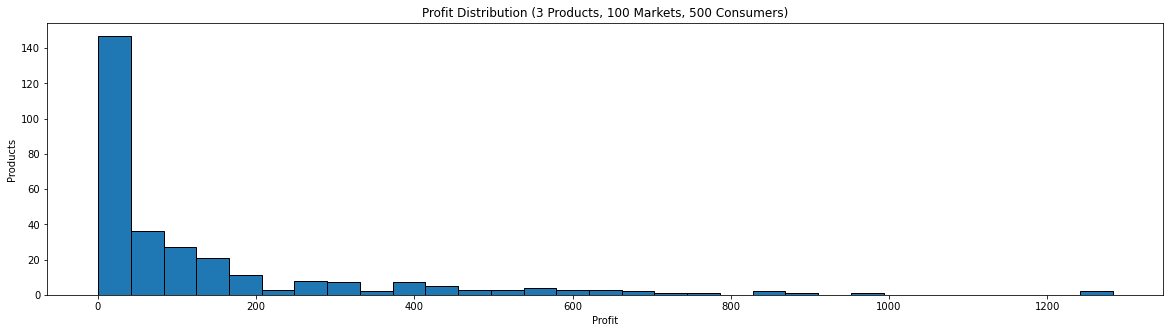

In [35]:
plot_empirical_profit(mkts,prods,n_consumers,sigma_hat,alpha_hat,P_opt,nu_i_fixed,'oligopoly')

Finally, to get the consumer surplus, we need to just get $\delta$ for our given value of $\sigma_{\alpha}$:

In [36]:
def plot_empirical_cs(mkts, prods, n_consumers, alpha_hat, sigma_hat, nu_i_vals, p_val):
    # get the alpha_i
    alpha_i = alpha_hat * nu_i_vals

    # get the market-product mean utility
    u_jm = get_delta(sigma_hat, nu_i_vals)

    # create a big system
    u_big = np.repeat(u_jm, n_consumers, axis = 0)
    p_big = np.repeat(p_val.T, n_consumers, axis = 0)

    # get the CS
    u = u_big - alpha_i * p_big
    cs = (.5772 + np.log(np.sum(np.exp(u), axis = 1))) / (alpha_i + sigma_hat).squeeze()
    cs_mean = np.mean(cs.reshape(100,500).clip(0), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins=int(np.ceil(cs_mean.max() - np.min([0., np.min(cs_mean)]))), ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

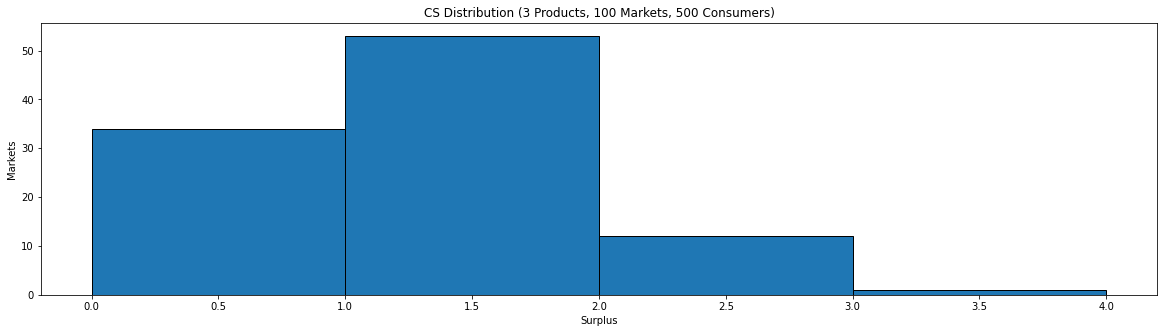

In [37]:
plot_empirical_cs(100,3,500,alpha_hat,sigma_hat,nu_i_fixed, P_opt)

At these parameter values, we see distributions that are roughly consistent with the surplus and profit distributions generated earlier.

**2e**. We now repeat the estimation for $M=10$:

In [121]:
mkts = 10
prods = 3

# set a seed
rand.seed(seed=800)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_Z = get_demand_instruments(x1, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, demand_Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

Optimization terminated successfully.
         Current function value: 2.416562
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.416562
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 8


<ipython-input-107-b1b8741aa919>:5: RuntimeWarning: overflow encountered in exp
  u_exp = np.exp(u_indiv)
<ipython-input-107-b1b8741aa919>:7: RuntimeWarning: invalid value encountered in true_divide
  s_indiv = u_exp / denom
<ipython-input-111-f9302e4f15e2>:9: RuntimeWarning: divide by zero encountered in log
  delta_new = delta_old + np.log(shares.T) - np.log(s_calc)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 220
         Gradient evaluations: 109
Optimization terminated successfully.
         Current function value: 2.416562
         Iterations: 8
         Function evaluations: 24
         Gradient evaluations: 12


In [39]:
{x: results_dict[x]['x'].item() for x in results_dict.keys()}

{1.0: 0.2127941114736475,
 2.0: 0.2127935293416015,
 3.0: -0.3087630714152229,
 4.0: 0.21279321981582858}

In [40]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])

,1.0,2.0,3.0,4.0
b1,1.398912,1.398912,-2.592345,1.398913
b2,0.169269,0.169269,-0.110174,0.169270
b3,1.417630,1.417630,2.565767,1.417630
a,-0.604868,-0.604869,-0.053827,-0.604869


In [126]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
sigma_hat = results_dict[1.0]['x'].reshape(-1,1)
theta1 = calculate_theta1(get_delta(sigma_hat, nu_i_fixed),x1,P_opt,demand_Z).reshape(-1,1)
all_params = np.concatenate([theta1,sigma_hat])
SEs = np.sqrt(np.diag(v_cov(prods,mkts,n_consumers,sigma_hat,demand_Z,x1, P_opt, nu_i_fixed) / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma'])

,value,SE,bias
b1,1.398912,5.789919e+06,-3.601088
b2,0.169269,2.170890e+06,-0.830731
b3,1.417630,3.225957e+05,0.417630
alpha,-0.604868,4.705048e+06,0.395132
sigma,0.212794,7.130757e+05,-0.787206


Due to small sample, the estimates are very biased, and the standard errors (especially on $\sigma_{\alpha}$) are extremely large -- full disclosure, this issue only cropped up when I ran the code for the last time, I have no idea why it occurred, and I sincerely apologize.

**3**. To estimate using $\mathbb{E}[\xi|p] = 0$, we assume this is in addition to the other moments, as otherwise the model is underidentified and cannot be estimated. In this case, we have:

In [42]:
def get_demand_price_instruments(X,prods,mkts):
    z1 = X # own characteristics
    
    z2_list = [np.sum(z1[:,1:][(i*prods):((i+1)*prods)], axis = 0) for i in range(int(X.shape[0]/prods))]
    z2 = np.repeat(np.row_stack(z2_list), prods, axis = 0) - z1[:,1:] # sum characteristics for the firm's products, subtract z1
    
    p = P_opt.T.reshape(-1,1)
    return(np.column_stack([z1,z2,p]))

In [43]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=700)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_price_Z = get_demand_price_instruments(x1, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, demand_price_Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

Optimization terminated successfully.
         Current function value: 0.001765
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001765
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001765
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001765
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7


In [44]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_price_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])

,1.0,2.0,3.0,4.0
b1,4.875405,4.875405,4.875405,4.875405
b2,0.919056,0.919056,0.919056,0.919056
b3,1.025176,1.025176,1.025176,1.025176
a,-0.913011,-0.913011,-0.913011,-0.913011


Despite the fact that the moment is not valid, we see parameter estimates that are quite close to the true parameters, and closer than the BLP-moment parameter estimates without using price. I'm not entirely sure why this is!

## 3. Adding Supply Side Instruments
___

**1a**. In this case, we again will have moments given by
$$\mathbb{E}\left[\left[X_i, \sum_{j\in t}X_{j\neq i}, W_i\right]^{\top}\xi_i\right] = 0$$

In [45]:
def get_demand_supply_instruments(X,W,prds,mkts):
    z1 = X # own characteristics
    
    z2_list = [np.sum(z1[:,1:][(i*prods):((i+1)*prods)], axis = 0) for i in range(int(X.shape[0]/prods))]
    z2 = np.repeat(np.row_stack(z2_list), prods, axis = 0) - z1[:,1:] # sum characteristics for the firm's products, subtract z1
    
    return(np.column_stack([z1,z2,w]))

In [46]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_supply_Z = get_demand_supply_instruments(x1, w, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, demand_supply_Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

         Current function value: 1.156932
         Iterations: 3
         Function evaluations: 68
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 1.156932
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 1.156932
         Iterations: 7
         Function evaluations: 18
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.156932
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 7


In [47]:
{x: results_dict[x]['x'].item() for x in results_dict.keys()}

{1.0: 0.9913593083826436,
 2.0: 0.9913592996949755,
 3.0: 0.9913593009898286,
 4.0: 0.9913593003479415}

In [48]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_supply_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])

,1.0,2.0,3.0,4.0
b1,5.001371,5.001371,5.001371,5.001371
b2,0.971426,0.971426,0.971426,0.971426
b3,1.035206,1.035206,1.035206,1.035206
a,-0.987083,-0.987083,-0.987083,-0.987083


In [49]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
sigma_hat = results_dict[1.0]['x'].reshape(-1,1)
theta1 = calculate_theta1(get_delta(sigma_hat, nu_i_fixed),x1,P_opt,demand_supply_Z).reshape(-1,1)
all_params = np.concatenate([theta1,sigma_hat])
SEs = np.sqrt(np.diag(v_cov(prods,mkts,n_consumers,sigma_hat,demand_supply_Z,x1, P_opt, nu_i_fixed) / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma'])

,value,SE,bias
b1,5.001371,0.689830,0.001371
b2,0.971426,0.130019,-0.028574
b3,1.035206,0.120773,0.035206
alpha,-0.987083,0.130267,0.012917
sigma,0.991359,0.267266,-0.008641


These estimates are extremely close to the true values, with all bias terms less than $.1$.

In [50]:
alpha_hat = -1 * theta1[3]
all_elasticities = get_elasticities(mkts, prods, n_consumers, sigma_hat, alpha_hat, P_opt, nu_i_fixed)

It's difficult to report so many elasticities, so I provide an example with the first market (the rows represent the $p_j$, and the columns the $s_k$):

In [51]:
pd.DataFrame(all_elasticities[:3])

,0,1,2
0,-8.368010,0.000495,0.000626
1,2.086539,-0.874782,2.760340
2,0.540607,0.565279,-3.654581


The other metric that's reported in BLP is the number of firms (here I will use the percentage of total firms) that have inelastic same-price elasticity:

In [52]:
own_elasticity = all_elasticities * np.tile(np.eye(prods), (mkts,1))
own_elasticity = own_elasticity[np.where(own_elasticity != 0)]

inelastic_elasticities = np.sum(own_elasticity > -1.) / len(own_elasticity)
print('{}% of firms are pricing in the inelastic part of demand.'.format(round(inelastic_elasticities* 100, 2)))

8.33% of firms are pricing in the inelastic part of demand.


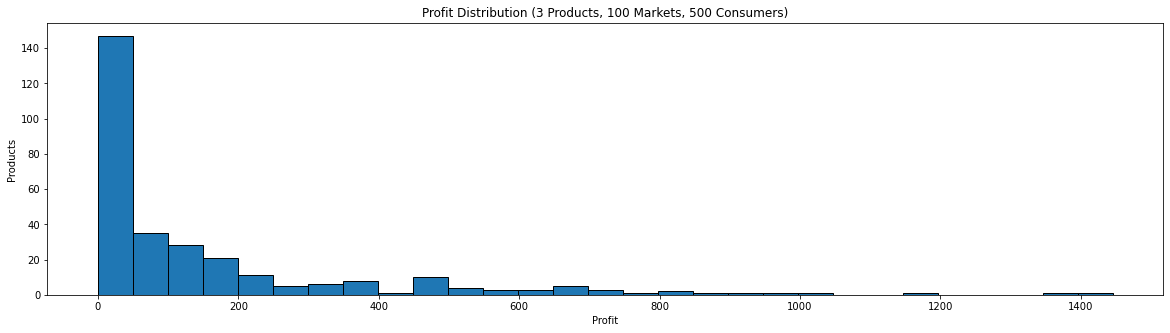

In [53]:
plot_empirical_profit(mkts,prods,n_consumers,sigma_hat,alpha_hat,P_opt,nu_i_fixed,'oligopoly')

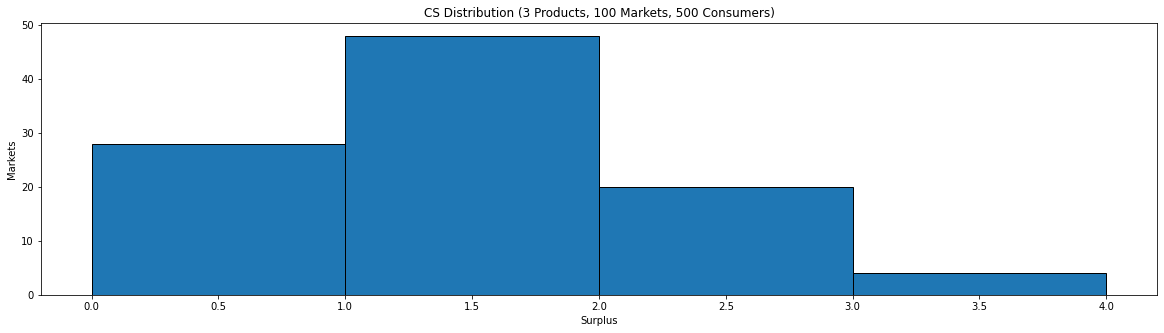

In [54]:
plot_empirical_cs(mkts, prods, n_consumers, alpha_hat, sigma_hat, nu_i_fixed, P_opt)

Given that our estimates are so close, we see values that are very similar to the true ones; the only difference is really generated by the choice of $\nu_i$.

**1c**. Estimation using 10 markets:

In [55]:
mkts = 10
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_supply_Z = get_demand_supply_instruments(x1, w, prods, mkts)

# optimize GMM for different values

results_dict = {x: gmm_min(x, demand_supply_Z, nu_i_fixed) for x in np.arange(1.,5.,1.)}

Optimization terminated successfully.
         Current function value: 128.620438
         Iterations: 3
         Function evaluations: 16
         Gradient evaluations: 8
         Current function value: 128.620438
         Iterations: 6
         Function evaluations: 28
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 128.620438
         Iterations: 7
         Function evaluations: 22
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 128.620438
         Iterations: 8
         Function evaluations: 26
         Gradient evaluations: 13


In [56]:
{x: results_dict[x]['x'].item() for x in results_dict.keys()}

{1.0: 0.3383010070495264,
 2.0: 0.33830095344085553,
 3.0: 0.33830110427650956,
 4.0: 0.3383010838443483}

In [57]:
pd.DataFrame(data = {str(s_val): calculate_theta1(get_delta(results_dict[s_val]['x'], nu_i_fixed),x1,P_opt,demand_supply_Z).squeeze() for s_val in results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a'])

,1.0,2.0,3.0,4.0
b1,0.420653,0.420653,0.420653,0.420653
b2,0.190285,0.190285,0.190285,0.190285
b3,1.588676,1.588676,1.588676,1.588676
a,-0.057426,-0.057426,-0.057426,-0.057426


In [58]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
sigma_hat = results_dict[1.0]['x'].reshape(-1,1)
theta1 = calculate_theta1(get_delta(sigma_hat, nu_i_fixed),x1,P_opt,demand_supply_Z).reshape(-1,1)
all_params = np.concatenate([theta1,sigma_hat])
SEs = np.sqrt(np.diag(v_cov(prods,mkts,n_consumers,sigma_hat,demand_supply_Z,x1, P_opt, nu_i_fixed) / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma'])

,value,SE,bias
b1,0.420653,8.290193,-4.579347
b2,0.190285,0.888844,-0.809715
b3,1.588676,1.473756,0.588676
alpha,-0.057426,1.733137,0.942574
sigma,0.338301,1.119679,-0.661699


**1d**. We see that this bias is decreased somewhat from the previous case, and the SEs are smaller, but the estimates are still quite poor in general (large absolute bias).

**2a**. We can here use our elasticity formulations. If there is perfect competition, we know that $MC = P$ and we can just use the prices as marginal costs.

If this is oligopoly, and each firm is only pricing for their one product, we will have $\Delta$ given by

$$\Delta = \begin{bmatrix}
-\frac{\partial s_{11}}{\partial p_{11}} & 0 & 0 & ... & 0 \\
0 & -\frac{\partial s_{12}}{\partial p_{12}} & 0 & ... & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & ... & -\frac{\partial s_{(m-1)(j-1)}}{\partial p_{(m-1)(j-1)}} & 0 \\
0 & 0 & 0 & ... & -\frac{\partial s_{mj}}{\partial p_{mj}}
\end{bmatrix}$$

which yields $MC = P - \Delta^{-1}s$

Under perfect collusion, all firms care about the impact of price changes on the shares of other products in their market:
$$\Delta = \begin{bmatrix}
-\frac{\partial s_{11}}{\partial p_{11}} & -\frac{\partial s_{12}}{\partial p_{11}} & -\frac{\partial s_{13}}{\partial p_{11}} & ... & -\frac{\partial s_{1j}}{\partial p_{11}} & 0 & 0 & ... & 0 \\
-\frac{\partial s_{11}}{\partial p_{12}} & -\frac{\partial s_{12}}{\partial p_{12}} & -\frac{\partial s_{13}}{\partial p_{12}} & ... & -\frac{\partial s_{1j}}{\partial p_{12}} & 0 & 0 & ... & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & ... & 0 & ... & -\frac{\partial s_{m(j-2)}}{\partial p_{mj}} & -\frac{\partial s_{m(j-1)}}{\partial p_{mj}} & -\frac{\partial s_{mj}}{\partial p_{mj}}
\end{bmatrix}$$

which yields $MC = P - \Delta^{-1}s$. My most preferred parameters at this point are the ones that use the $W$ moment, as they are stable and extremely close to the true parameters. In reality we wouldn't know this, so the justification is that the moment seems valid, so its addition should help identification.
<!-- We then calculate $\Delta$. As firms produce one good per market, $\Delta$ will be diagonal, with elements given by
$$-\frac{\partial s_j}{\partial p_j}$$
For an individual $i$, the choice probability of choosing product $j$ is given by
$$\mathbb{P}_{ij} = \frac{\exp(\delta_j - p_j \nu_i \sigma_{\alpha})}{1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})}$$
This means that
$$\frac{\partial \mathbb{P}_{ij}}{\partial p_j} = \frac{\left(1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})\right)\exp(\delta_j - p_j \nu_i \sigma_{\alpha})(-\alpha - \sigma_{\alpha}\nu_i) - \exp(\delta_j - p_j \nu_i \sigma_{\alpha})^2(-\alpha - \sigma_{\alpha}\nu_i)}{\left(1 + \sum_{k=1}^J\exp(\delta_k - p_k \nu_i \sigma_{\alpha})\right)^2}$$
and
$$-\frac{\partial s_j}{\partial p_j} = -\frac{1}{n}\sum_{i=1}^{ns}\frac{\partial \mathbb{P}_{ij}}{\partial p_j}$$
Given our shares formulation, we have
$$-\frac{\partial s_j}{\partial p_j} = -\frac{1}{n}\sum_{i=1}^{500}\frac{(1+\sum_s{\exp(\delta_s + \mu_{is})})(-\alpha-\sigma_{\alpha}\nu_i)\exp(\delta_j + \mu_{ij}) + (\alpha + \sigma_{\alpha}\nu_i)(\exp(\delta_j + \mu_{ij}))^2}{(1+\sum_s{\exp(\delta_s + \mu_{is})})^2}$$
Simplifying yields
$$\frac{\partial s_j}{\partial p_j} = \frac{1}{n}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}^2 - s_{ij})$$
and
$$\frac{\partial s_j}{\partial p_k} = \frac{1}{n}\sum_{i=1}^{500}(\alpha + \sigma_{\alpha}\nu_i)(s_{ij}s_{ik})$$ -->

In [59]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments
demand_supply_Z = get_demand_supply_instruments(x1, w, prods, mkts)

# optimize GMM for different values

best_result = gmm_min(2., demand_supply_Z, nu_i_fixed)

best_sigma_hat = best_result['x']
best_theta_hat = calculate_theta1(get_delta(best_sigma_hat,nu_i_fixed),x1,P_opt,demand_supply_Z)
best_alpha_hat = -1.0 * best_theta_hat[-1]

mc_true = (np.column_stack([np.ones(prods * mkts),w, Z]) @ gamma + eta).reshape(mkts,prods)

mc_perf_comp = P_opt.T - get_markup(mkts,prods,n_consumers,best_sigma_hat,best_alpha_hat,P_opt,nu_i_fixed, 'perfect').reshape(mkts, prods)
mc_olig = P_opt.T - get_markup(mkts,prods,n_consumers,best_sigma_hat,best_alpha_hat,P_opt,nu_i_fixed, 'oligopoly').reshape(mkts, prods)
mc_collusion = P_opt.T - get_markup(mkts,prods,n_consumers,best_sigma_hat,best_alpha_hat,P_opt,nu_i_fixed, 'collusion').reshape(mkts, prods)

pd.DataFrame(data = {'mc_true': mc_true.reshape(-1),
                     'mc_perf_comp': mc_perf_comp.reshape(-1),
                     'mc_olig': mc_olig.reshape(-1),
                     'mc_collusion': mc_collusion.reshape(-1)}).describe()

Optimization terminated successfully.
         Current function value: 1.156932
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 5


,mc_true,mc_perf_comp,mc_olig,mc_collusion
count,300.000000,300.000000,300.000000,300.000000
mean,2.051214,3.026549,2.039062,-0.864475
std,1.577606,1.371157,1.587145,3.650507
min,-2.259204,0.163102,-2.551699,-28.011963
25%,0.847252,1.988151,0.852680,-1.760007
50%,2.047371,2.827857,2.034270,-0.424633
75%,3.181108,3.963675,3.169196,1.071435
max,6.283119,7.028482,6.272998,5.627979


As we can see, the marginal costs under oligopoly with our preferred parameters are almost identical to the marginal costs generated by the true model.

**2c**. To compute all the parameters under these assumptions, we need to get the values of $\hat{\omega}$ by using the pricing assumption, and then feed that into the new GMM criterion function. Thus, we need to add code to get the GMM criterion.

In [60]:
def calculate_gamma(P,markup_vals,w_val,Z):
    # get the marginal cost
    mc = P.T - markup_vals
    
    # projection matrix
    P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    
    return(np.linalg.inv(w_val.T @ P_Z @ w_val) @ w_val.T @ P_Z @ mc.reshape(-1,1))

In [61]:
def calculate_omega_hat(P,markup_vals,w_val,Z):
    # get the marginal cost
    mc = P.T - markup_vals
    
    # get the gamma hat
    gamma_hat = calculate_gamma(P,markup_vals,w_val,Z)
    
    return(mc.reshape(-1,1) - w_val @ gamma_hat)

In [62]:
def gmm_supply_obj(sigma, Z_val, nu_i_vals, comp_type):
    
    # demand side
    delta_new = get_delta(sigma,nu_i_vals)
    theta1_hat = calculate_theta1(delta_new,x1,P_opt,Z)
    alpha_hat = -1. * theta1_hat[-1]
    xi_hat = get_xi_hat(delta_new,x1,P_opt,Z_val)
    
    # supply side
    markups = get_markup(mkts,prods,n_consumers,sigma,alpha_hat,P_opt,nu_i_vals,comp_type).reshape(-1,1)
    w_input = np.column_stack([np.ones(prods * mkts),w, Z])
    omega_hat = calculate_omega_hat(P_opt, markups.reshape(mkts,prods), w_input, Z_val)
    
    W = np.linalg.inv(Z_val.T @ Z_val / len(Z))
    
    # combine residuals
    resids = np.concatenate([xi_hat,omega_hat])
    
    # create block matrices
    big_Z = sp.linalg.block_diag(Z_val,Z_val)
    big_W = sp.linalg.block_diag(W,W)
    
    return((resids.T @ big_Z @ big_W @ big_Z.T @ resids).item())

In [63]:
def gmm_supply_min(start_val, Z_val, nu_i_vals, comp_type):
    return(
        op.minimize(
            gmm_supply_obj, 
            x0 = start_val, 
            args = (Z_val, nu_i_vals, comp_type), 
            #method='Nelder-Mead',
            options = {'disp': True}
        )
    )

In [64]:
mkts = 100
prods = 3

# set a seed
rand.seed(seed=900)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
nu_i_fixed = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)

# get instruments

demand_supply_Z = get_demand_supply_instruments(x1, w, prods, mkts)

# optimize GMM for different values

pc_results_dict = {x: gmm_supply_min(x, demand_supply_Z, nu_i_fixed, 'perfect') for x in np.arange(1.,5.,1.)}
olig_results_dict = {x: gmm_supply_min(x, demand_supply_Z, nu_i_fixed, 'oligopoly') for x in np.arange(1.,5.,1.)}
coll_results_dict = {x: gmm_supply_min(x, demand_supply_Z, nu_i_fixed, 'collusion') for x in np.arange(1.,5.,1.)}

         Current function value: 2266.285515
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 2266.285515
         Iterations: 5
         Function evaluations: 16
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2266.285515
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2266.285515
         Iterations: 7
         Function evaluations: 20
         Gradient evaluations: 10
         Current function value: 940.782452
         Iterations: 4
         Function evaluations: 92
         Gradient evaluations: 40
         Current function value: 940.782452
         Iterations: 5
         Function evaluations: 58
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 940.

In [65]:
def get_all_params(s_val, results_dict_val, comp_type):
    s_hat = results_dict_val[s_val]['x']
    theta1_val = calculate_theta1(get_delta(s_hat, nu_i_fixed),x1,P_opt,demand_supply_Z).squeeze()
    w_input = np.column_stack([np.ones(prods * mkts),w, Z])
    markups = get_markup(mkts,prods,n_consumers,s_hat,-1. * theta1_val[-1],P_opt,nu_i_fixed,comp_type).reshape(mkts, prods)
    gamma_val = calculate_gamma(P_opt,markups,w_input,demand_supply_Z).squeeze()
    return(np.concatenate([theta1_val,s_hat,gamma_val]))


In [66]:
def v_cov_supply(prods, mkts, n_consumers, sigma, alpha, Z, X, P, w_val, nu_i_vals, comp_type):
    # get implied delta and shares
    delta = get_delta(sigma, nu_i_vals)
    share_vals = get_shares(mkts,prods,n_consumers,P.T,delta,sigma,nu_i_vals)

    # get individual shares
    u_exp = np.exp(np.repeat(delta, n_consumers, axis = 0) - sigma * np.repeat(P.T, n_consumers, axis = 0) * nu_i_vals.reshape(-1,1))
    sum_terms = 1. + np.sum(u_exp, axis = 1).reshape(-1,1)
    indiv_shares = (u_exp / sum_terms)

    indiv_mkts_x_shares = [indiv_shares[i].reshape(-1,1) @ indiv_shares[i].reshape(1,-1) for i in range(len(indiv_shares))]
    cross_shares_matrix = np.concatenate(indiv_mkts_x_shares, axis = 0)
    own_shares_ind = np.repeat(indiv_shares, prods, axis = 0) * np.tile(np.eye(prods), (n_consumers * mkts,1))
    total_mat = own_shares_ind - cross_shares_matrix

    # get the averages by market
    mkt_avg = []
    for i in range(mkts):    
        mkt_block = [total_mat[j:(j+prods)] for j in range(i * prods * n_consumers, (i+1) * prods * n_consumers, prods)]
        mkt_avg.append(np.mean(mkt_block, axis = 0))

    ds_ddelta_inv = np.linalg.inv(sp.linalg.block_diag(*mkt_avg))

    # get the ds/dsigma derivatives and get the product
    row_sums = np.sum(np.repeat(P.T, n_consumers, axis = 0) * indiv_shares, axis = 1)
    diff_terms = np.repeat(P.T, n_consumers, axis = 0) - row_sums.reshape(-1,1)
    prod_terms = -1. * indiv_shares * nu_i_vals * diff_terms
    
    ds_dsigma = np.concatenate([np.mean(prod_terms[(i * 500):((i+1) * 500)], axis = 0).reshape(-1,1) for i in range(mkts)])
    ddelta_dsigma = ds_ddelta_inv @ ds_dsigma
    
    # get total obs
    n = prods * mkts
    
    # get weighting matrices
    W = sp.linalg.block_diag(*[np.linalg.inv(Z.T @ Z / n)] * 2)
    T = sp.linalg.sqrtm(np.linalg.inv(Z.T @ Z / n))
    
    # get the derivatives
    d_beta = -Z.T @ X
    d_alpha = Z.T @ P.T.reshape(-1,1) 
    d_sigma = Z.T @ ddelta_dsigma
    d_gamma = -Z.T @ w_val
    
    # create gamma matrix by stacking the individual conditions
    G = sp.linalg.block_diag(*[np.column_stack([d_beta,d_alpha,d_sigma]), d_gamma]) / n
    G_term = np.linalg.inv(G.T @ W @ G) @ G.T
    
    # get V1 by getting the variance of the Z * xi terms
    xi_hat = get_xi_hat(get_delta(sigma, nu_i_vals), X, P, Z)
    markup_vals = get_markup(mkts,prods,n_consumers,sigma,alpha,P,nu_i_vals,comp_type).reshape(mkts,prods)
    omega_hat = calculate_omega_hat(P,markup_vals,w_val,Z)
    Z_e = Z * xi_hat @ T
    Z_w = Z * omega_hat @ T
    V1 = sp.linalg.block_diag(*[Z_e.T @ Z_e, Z_w.T @ Z_w]) / n
    
    # get V3 by getting the empirical variance from drawing nu 100 times
    ns_sims = []
    s = 25
    for i in range(s):
        nu_i = rand.lognormal(size = n_consumers * mkts).reshape(-1,1)
        xi_hat = get_xi_hat(get_delta(sigma, nu_i), X, P, Z)
        markup_vals = get_markup(mkts,prods,n_consumers,sigma,alpha,P,nu_i,comp_type).reshape(mkts,prods)
        omega_hat = calculate_omega_hat(P,markup_vals,w_val,Z)
        Z_xi = Z * xi_hat
        Z_xi_mean = np.mean(Z_xi, axis = 0).reshape(-1,1)
        Z_w = Z * omega_hat
        Z_w_mean = np.mean(Z_w, axis = 0).reshape(-1,1)
        ns_sims.append(sp.linalg.block_diag(*[Z_xi.T @ Z_xi - Z_xi_mean @ Z_xi_mean.T,
                                             Z_w.T @ Z_w - Z_w_mean @ Z_w_mean.T]) / n)
        
    V3 = np.mean(ns_sims, axis = 0)
        
    return(G_term @ (V1 + V3) @ G_term.T)

The results under perfect competition:

In [69]:
pd.DataFrame(data = {str(s_val): get_all_params(s_val, pc_results_dict, 'perfect') for s_val in pc_results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a', 'sigma', 'g1', 'g2', 'g3'])

,1.0,2.0,3.0,4.0
b1,5.001371,5.001371,5.001371,5.001371
b2,0.971426,0.971426,0.971426,0.971426
b3,1.035206,1.035206,1.035206,1.035206
a,-0.987083,-0.987083,-0.987083,-0.987083
sigma,0.991359,0.991359,0.991359,0.991359
g1,2.942239,2.942239,2.942239,2.942239
g2,0.767749,0.767749,0.767749,0.767749
g3,0.558340,0.558340,0.558340,0.558340


In [70]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
W = np.column_stack([np.ones(mkts*prods), w, Z])

all_params = get_all_params(1.0, pc_results_dict, 'perfect')
sigma_hat = all_params[4]
alpha_hat = -1 * all_params[3]

SEs = np.sqrt(np.diag(v_cov_supply(prods,mkts,n_consumers,sigma_hat,alpha_hat,demand_supply_Z, x1, P_opt, W, nu_i_fixed, 'oligopoly') / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.,2.,1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma', 'g1', 'g2', 'g3'])

,value,SE,bias
b1,5.001371,0.690337,0.001371
b2,0.971426,0.130079,-0.028574
b3,1.035206,0.120976,0.035206
alpha,-0.987083,0.130568,0.012917
sigma,0.991359,0.267659,-0.008641
g1,2.942239,0.165530,0.942239
g2,0.767749,0.089279,-0.232251
g3,0.558340,0.753378,-0.441660


The results under oligopoly:

In [72]:
pd.DataFrame(data = {str(s_val): get_all_params(s_val, olig_results_dict, 'oligopoly') for s_val in olig_results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a', 'sigma', 'g1', 'g2', 'g3'])

,1.0,2.0,3.0,4.0
b1,4.999679,4.999679,4.999679,4.999679
b2,0.971111,0.971111,0.971111,0.971111
b3,1.034968,1.034968,1.034968,1.034968
a,-0.987184,-0.987184,-0.987184,-0.987184
sigma,0.990740,0.990740,0.990740,0.990740
g1,1.939568,1.939568,1.939568,1.939568
g2,0.980332,0.980332,0.980332,0.980332
g3,0.908110,0.908110,0.908110,0.908110


In [73]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
all_params = get_all_params(1.0, olig_results_dict, 'oligopoly')
sigma_hat = all_params[4]
alpha_hat = -1 * all_params[3]

SEs = np.sqrt(np.diag(v_cov_supply(prods,mkts,n_consumers,sigma_hat,alpha_hat,demand_supply_Z, x1, P_opt, W, nu_i_fixed, 'oligopoly') / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.,2.,1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma', 'g1', 'g2', 'g3'])

,value,SE,bias
b1,4.999679,0.687077,-0.000321
b2,0.971111,0.129485,-0.028889
b3,1.034968,0.120489,0.034968
alpha,-0.987184,0.129782,0.012816
sigma,0.990740,0.266058,-0.009260
g1,1.939568,0.165527,-0.060432
g2,0.980332,0.089231,-0.019668
g3,0.908110,0.752825,-0.091890


The results under perfect collusion:

In [74]:
pd.DataFrame(data = {str(s_val): get_all_params(s_val, coll_results_dict, 'collusion') for s_val in coll_results_dict.keys()},
             index = ['b1', 'b2', 'b3', 'a', 'sigma', 'g1', 'g2', 'g3'])

,1.0,2.0,3.0,4.0
b1,4.578728,4.578728,4.597648,4.578728
b2,0.893466,0.893466,0.896921,0.893466
b3,0.976269,0.976269,0.978877,0.976269
a,-1.014988,-1.014988,-1.013607,-1.014988
sigma,0.834533,0.834533,0.841653,0.834533
g1,-0.759436,-0.759436,-0.758327,-0.759436
g2,0.759013,0.759013,0.759008,0.759013
g3,4.911279,4.911280,4.934495,4.911279


In [75]:
# we arbitrarily take the first run for sigma_hat and return all the parameters
all_params = get_all_params(1.0, coll_results_dict, 'collusion')
sigma_hat = all_params[4]
alpha_hat = -1 * all_params[3]

SEs = np.sqrt(np.diag(v_cov_supply(prods,mkts,n_consumers,sigma_hat,alpha_hat,demand_supply_Z, x1, P_opt, W, nu_i_fixed, 'oligopoly') / len(x1)))
bias = all_params.squeeze() - np.array([5.,1.,1.,-1.,1.,2.,1.,1.])
pd.DataFrame(data = {'value': all_params.squeeze(),
                     'SE': SEs.squeeze(),
                     'bias': bias.squeeze()},
             index = ['b1', 'b2', 'b3', 'alpha', 'sigma', 'g1', 'g2', 'g3'])

,value,SE,bias
b1,4.578728,0.679500,-0.421272
b2,0.893466,0.124163,-0.106534
b3,0.976269,0.117085,-0.023731
alpha,-1.014988,0.132435,-0.014988
sigma,0.834533,0.273255,-0.165467
g1,-0.759436,0.167037,-2.759436
g2,0.759013,0.090244,-0.240987
g3,4.911279,0.762229,3.911279


We see that the oligopoly results are extremely close, and we use them to compute the elasticities.

In [76]:
alpha_hat = -1 * theta1[3]
all_elasticities = get_elasticities(mkts, prods, n_consumers, sigma_hat, alpha_hat, P_opt, nu_i_fixed)

It's difficult to report so many elasticities, so I provide an example with the first market (the rows represent the $p_j$, and the columns the $s_k$):

In [77]:
pd.DataFrame(all_elasticities[:3])

,0,1,2
0,-2.291845,0.000136,0.000161
1,0.572485,-0.474063,1.122347
2,0.138765,0.229841,-1.570724


The other metric that's reported in BLP is the number of firms (here I will use the percentage of total firms) that have inelastic same-price elasticity:

In [78]:
own_elasticity = all_elasticities * np.tile(np.eye(prods), (mkts,1))
own_elasticity = own_elasticity[np.where(own_elasticity != 0)]

inelastic_elasticities = np.sum(own_elasticity > -1.) / len(own_elasticity)
print('{}% of firms are pricing in the inelastic part of demand.'.format(round(inelastic_elasticities* 100, 2)))

29.67% of firms are pricing in the inelastic part of demand.


We see that the elasticity results are very consistent with what we've seen previously, as well as the true values.

## Merger exercise
___
**1**. The best parameters are the ones calculated with the assumption of oligopoly -- they come extremely close to recovering the correct values, and are justifiable ex ante because the marginal costs are close to those implied by the true model.

**2a**. The pricing problem is
$$\max_{p_{1t},p_{2t}}\;(p_{1t}-mc_{1t})s_{1t} + (p_{2t}-mc_{2t})s_{2t}$$
The first order condition is
$$s_{it} + \frac{\partial s_{it}}{\partial p_{it}}(p_{1t} - mc_{1t}) +\frac{\partial s_{-it}}{\partial p_{it}}(p_{-it}-mc_{-it}) = 0 \quad i \in \{1,2\}$$
**2b**. To get the new prices, we compute the markup and estimated marginal cost, and then add them to get the new prices.

In [80]:
best_params = get_all_params(1.0, olig_results_dict, 'oligopoly')
sigma_hat = olig_results_dict[1.0]['x'].item()
alpha_hat = best_params[3]

In [81]:
def get_merger_markup(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals):
    post_merger_mat = np.array([1.,1.,0.,1.,1.,0.,0.,0.,1.]).reshape(3,3)
    s_hat = get_shares(mkts,prods,n_consumers,price_vals.T,get_delta(sigma,nu_i_vals),sigma,nu_i_vals)
    elas = get_elasticities(mkts,prods,n_consumers,sigma,alpha,price_vals,nu_i_vals) * np.repeat(s_hat,prods,axis = 0) / price_vals.T.reshape(-1,1)
    Delta = -1 * sp.linalg.block_diag(*[elas[(i*prods):((i+1) * prods)] for i in range(mkts)]) * sp.linalg.block_diag(*[post_merger_mat] * mkts)
    markup = np.linalg.inv(Delta) @ s_hat.reshape(-1,1)
    return(markup)

In [83]:
new_markups = get_merger_markup(mkts,prods,n_consumers,sigma_hat,-1. * alpha_hat,P_opt,nu_i_fixed).reshape(mkts,prods)
old_markups = get_markup(mkts,prods,n_consumers,sigma_hat,-1. * alpha_hat,P_opt,nu_i_fixed, 'oligopoly').reshape(mkts,prods)
mc_est = (np.column_stack([np.ones(prods * mkts),w, Z]) @ best_params[5:]).reshape(mkts,prods)

new_p = new_markups + mc_est

As we can see below, the merger causes the newly merged firm to increase the markup for both of its products (the table below shows the distribution of the change in markup):

In [84]:
pd.DataFrame(data = new_markups - old_markups).describe()

,0,1,2
count,100.000000,100.000000,100.0
mean,0.942774,0.365064,0.0
std,0.912031,0.636623,0.0
min,0.001375,0.000018,0.0
25%,0.197441,0.031972,0.0
50%,0.632349,0.112631,0.0
75%,1.404685,0.351339,0.0
max,3.891815,4.332624,0.0


**2c**. We plot the variables below:

In [85]:
def plot_new_prices(mkts, prods, p):
    p_flat = p.reshape(prods * mkts)
    plt.hist(p_flat, bins=int(np.ceil(p_flat.max() - np.min([0., np.min(p_flat)]))*2), ec='black', range=(np.floor(np.min([0., np.min(p_flat)])), np.ceil(p_flat.max())))
    plt.title('Price Distribution ({} Products, {} Markets)'.format(prods, mkts))
    plt.xlabel('Price')
    plt.ylabel('Products')
    plt.show()

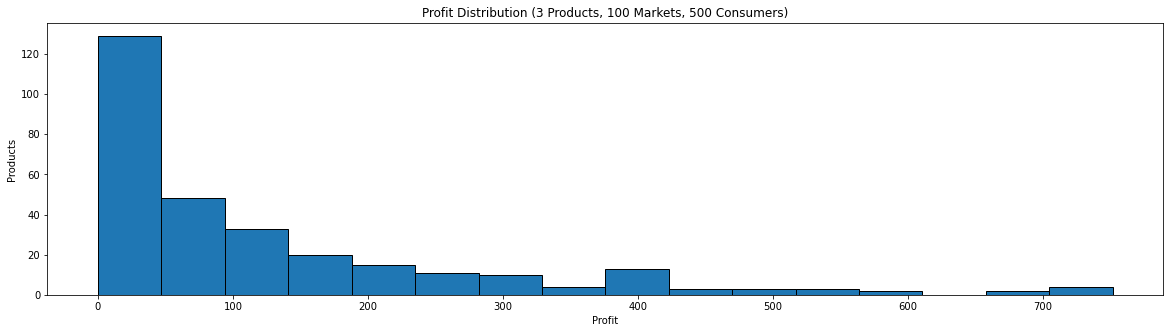

In [88]:
plot_empirical_profit(mkts,prods,n_consumers,sigma_hat,-1. * alpha_hat,new_p.T,nu_i_fixed,'oligopoly')

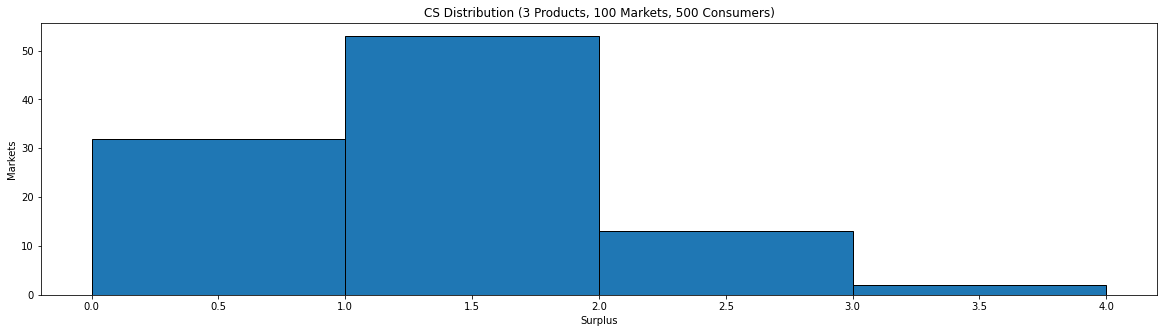

In [89]:
plot_empirical_cs(mkts, prods, n_consumers, -1. * alpha_hat, sigma_hat, nu_i_fixed, new_p.T)

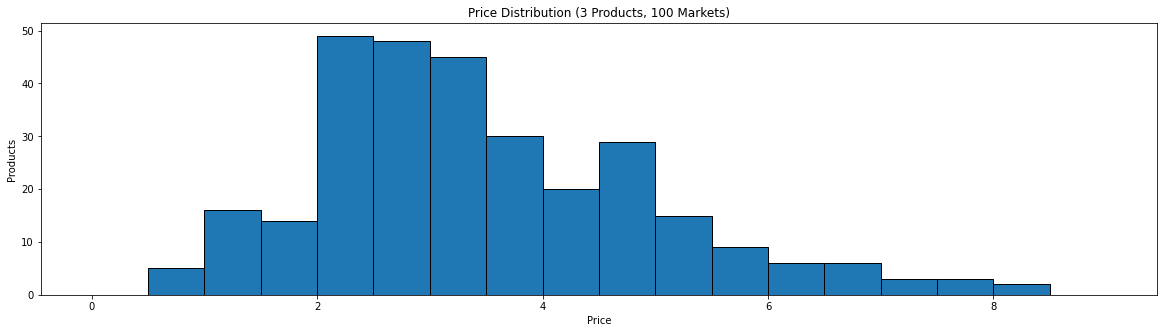

In [90]:
plot_new_prices(100,3,new_p)

As expected, we see that if the firms merge, prices are higher, profits are higher, and consumer surplus is correspondingly lower. This is why the DOJ attempts to restrict the ability of firms to merge with impunity, as it has a deleterious impact on consumers.